In [1]:
import torch
import sklearn

import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt


transformBegin = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


train_data_CIFAR10 = datasets.CIFAR10(
    root="CIFAR10",
    train=True,
    download=True,
    transform=transformBegin,
    target_transform=None
)

test_data_CIFAR10 = datasets.CIFAR10(
    root="CIFAR10",
    train=False,
    download=True,
    transform=transformBegin,
    target_transform=None
)

Files already downloaded and verified
Files already downloaded and verified


In [2]:
import numpy as np

sample_image, label = train_data_CIFAR10[1]

sample_image.shape

torch.Size([3, 224, 224])

In [3]:
class_names = train_data_CIFAR10.classes
class_names

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


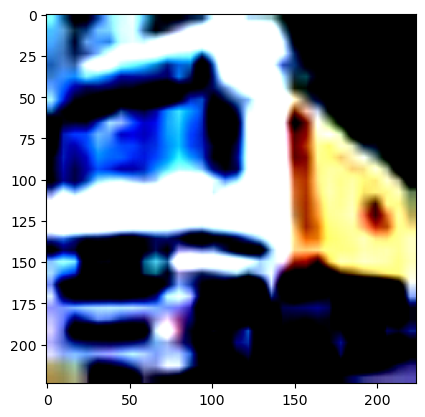

In [4]:
import matplotlib.pyplot as plt
import numpy as np

image, label = train_data_CIFAR10[1]

image_array = np.transpose(image.numpy(), (1, 2, 0))

plt.imshow(image_array.squeeze(), cmap="gray")

In [5]:
from torch.utils.data import DataLoader, TensorDataset, SubsetRandomSampler


batch_size = 32
max_samples = 100

subset_indices = list(range(min(len(train_data_CIFAR10), max_samples)))
sampler = SubsetRandomSampler(subset_indices)

# Train
train_data_CIFAR10_transformed = DataLoader(train_data_CIFAR10, batch_size=batch_size, sampler=sampler)

# Test
test_data_CIFAR10_transformed = DataLoader(test_data_CIFAR10, batch_size=batch_size, shuffle=True)

In [6]:
import torch
from torch import nn
import torchvision.transforms as transforms
import torchvision.models as models
from PIL import Image

mobilenet_v2 = models.mobilenet_v2(pretrained=True)


# Modify classifier head for your specific task
num_classes = 10  # Number of classes in CIFAR-10
mobilenet_v2.classifier[1] = nn.Linear(mobilenet_v2.last_channel, num_classes)

/Users/rehanchoudhury/anaconda3/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/rehanchoudhury/anaconda3/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [7]:
# Perform inference

sample_inference_image, label = train_data_CIFAR10[0]

with torch.no_grad():
    output = mobilenet_v2(sample_inference_image.unsqueeze(dim=0))

# Get predicted class
predicted_class = torch.argmax(output, dim=1).item()

# Display prediction
print(f"Predicted class index: {predicted_class}")
output

Predicted class index: 3


tensor([[-0.2471, -0.3551, -0.4733,  0.6324, -0.5894,  0.4592, -0.0284,  0.1212,
         -0.7794,  0.3703]])

In [8]:
# Loss and optimizer
loss_fn = nn.CrossEntropyLoss() # is combines BCE with sigmoid

optimizer = torch.optim.SGD(params = mobilenet_v2.parameters(), lr=0.1)

In [10]:
from helpers import calculate_accuracy


def normalizePredictions(y_pred):
    vals = torch.softmax(y_pred, dim=1)
    return torch.argmax(vals, dim=1)

torch.manual_seed(42)

epochs = 10

train_epochs = []
train_loss_arr = []
test_loss_arr = []

for epoch in range(epochs):
    
    train_loss = 0;
    train_acc = 0;
    
    print(f"Epoch: {epoch}\n----------")
    
    train_epochs.append(epoch)
    
    for batch, (X, Y) in enumerate(train_data_CIFAR10_transformed):
        
        mobilenet_v2.train();
        
        y_logits_train = mobilenet_v2(X)
        
        loss = loss_fn(y_logits_train, Y)
        
        y_pred_train = normalizePredictions(y_logits_train)
        
        train_loss+=loss
        
        train_acc+=calculate_accuracy(Y ,y_pred_train)
        
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step()
        
        mobilenet_v2.eval()
            
    # Average train_loss        
    train_loss /= len(train_data_CIFAR10_transformed)
    train_acc /= len(train_data_CIFAR10_transformed)
    
    train_loss_arr.append(train_loss.item())
    
    print(f"Train loss for {epoch}: {train_loss} | Train acc: {train_acc}")
    
    ### Testing
    
    test_loss, test_acc = 0, 0
    
    with torch.inference_mode():
        for X_test, Y_test in train_data_CIFAR10_transformed:
            
            y_logits_test = mobilenet_v2(X_test)
        
            test_loss = loss_fn(y_logits_test, Y_test)
            
            test_loss+=test_loss
            
            y_pred_test = normalizePredictions(y_logits_test)
            
            test_acc+=calculate_accuracy(Y_test ,y_pred_test)
            
        test_loss/=len(train_data_CIFAR10_transformed)
        test_acc/=len(train_data_CIFAR10_transformed)
        
        test_loss_arr.append(test_loss.item())
        
        print(f"Test loss for {epoch}: {test_loss}, Test acc: {test_acc}")
    
    

Epoch: 0
----------
Train loss for 0: 7.82771110534668 | Train acc: 14.0625
Test loss for 0: 5.937983989715576, Test acc: 3.125
Epoch: 1
----------
Train loss for 1: 6.053192615509033 | Train acc: 11.71875
Test loss for 1: 25.421112060546875, Test acc: 4.6875
Epoch: 2
----------
Train loss for 2: 6.725220680236816 | Train acc: 9.375
Test loss for 2: 2.6010751724243164, Test acc: 14.0625
Epoch: 3
----------
Train loss for 3: 3.4360790252685547 | Train acc: 20.3125
Test loss for 3: 1.0189437866210938, Test acc: 14.84375
Epoch: 4
----------
Train loss for 4: 2.648062229156494 | Train acc: 16.40625
Test loss for 4: 1.8969841003417969, Test acc: 15.625
Epoch: 5
----------
Train loss for 5: 2.332702875137329 | Train acc: 22.65625
Test loss for 5: 2.151787757873535, Test acc: 10.15625
Epoch: 6
----------
Train loss for 6: 2.3107519149780273 | Train acc: 27.34375
Test loss for 6: 3.770070791244507, Test acc: 11.71875
Epoch: 7
----------
Train loss for 7: 2.1506271362304688 | Train acc: 22.6562